In [1]:
#standard library imports
import datetime
import itertools
import os
import random
import time
import warnings

#3rd party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

import nltk
from nltk.stem import PorterStemmer

In [2]:
train_df = pd.read_csv(
    "data/en/train_data_1.tsv",
    sep = "\t",
    header = 0,
    index_col = 0
)


langs=['en','it','fr','ge','po']#,'ru']
target_lang='en'
for i in langs:
    if i ==target_lang:
        train_df = pd.read_csv(
            "data/en/train_data_1.tsv",
            sep = "\t",
            header = 0,
            index_col = 0
        )
        print('Added en')
    else:
        train_df2 = pd.read_csv(
            'data/en/train_data_extra'+i+'.tsv',
            sep = "\t",
            header = 0,
            index_col = 0
        )
        print(i, 'Total:',len(train_df2))
        train_df=train_df.append(train_df2)
        print(len(train_df))


# Report the number of sentences.
print('Number of training articles: {:,}\n'.format(train_df.shape[0]))

FileNotFoundError: [Errno 2] No such file or directory: 'data/en/train_data_1.tsv'

In [ ]:
train_df

,text,type
id,,
833042063,Chelsea Handler Admits She’s ‘Very Sexually At...,satire
832959523,How Theresa May Botched\n\nThose were the time...,satire
833039623,Robert Mueller III Rests His Case—Dems NEVER W...,satire
833032367,Robert Mueller Not Recommending Any More Indic...,satire
814777937,The Far Right Is Trying to Co-opt the Yellow V...,satire
...,...,...
25181,Side effects after Novavax vaccine against Cov...,reporting
25164,The Together party asks the government about t...,reporting
25187,President Andrzej Duda signed the Act on the c...,reporting


In [ ]:
import re
import nltk
nltk.download('punkt')
from nltk import word_tokenize
def clean_text(sentence):
    '''
        function to clean content column, make it ready for transformation and modeling
    '''
    sentence = sentence.lower()                #convert text to lower-case
    sentence = re.sub('â€˜','',sentence)    # remove the text â€˜ which appears to occur flequently
    sentence = re.sub('[‘’“”…,":-]', '', sentence) # remove punctuation
    sentence = re.sub('[()@.?!]', '', sentence)  #remove parentheses
    sentence = re.sub("[^a-zA-Z]"," ",sentence) #remove numbers and keep text/alphabet only
    sentence = word_tokenize(sentence)      # remove repeated characters (tanzaniaaaaaaaa to tanzania)
    
    return ' '.join(sentence)

train_df['text'] = train_df['text'].apply(clean_text)   

[nltk_data] Downloading package punkt to
[nltk_data]     /home/osservatorio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


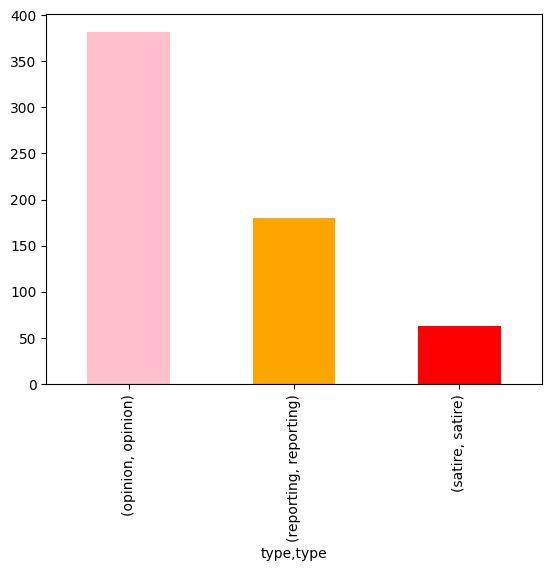

In [ ]:
train_df.groupby('type').type.value_counts().plot(kind = "bar", color = ["pink", "orange", "red"])
plt.show()

In [ ]:
def get_split(text1):
  len_t=400
  l_total = []
  l_parcial = []
  count=0
  if len(text1.split())//len_t >0:
    count += 1    
    n = len(text1.split())//len_t
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:len_t]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*len_t:w*len_t + len_t]
      l_total.append(" ".join(l_parcial))
  return l_total

splited=train_df['text'].apply(get_split).to_frame()
train_df['text_splited']=splited['text']

In [ ]:
train_df['split']=train_df['text_splited'].str.len()
train_df['article_id'] = train_df.index
train_df

,text,type,text_splited,split,article_id
id,,,,,
833042063,Chelsea Handler Admits Shes Very Sexually Attr...,satire,[Chelsea Handler Admits Shes Very Sexually Att...,1,833042063
832959523,How Theresa May Botched Those were the times T...,satire,[How Theresa May Botched Those were the times ...,2,832959523
833039623,Robert Mueller III Rests His Case—Dems NEVER W...,satire,[Robert Mueller III Rests His Case—Dems NEVER ...,2,833039623
833032367,Robert Mueller Not Recommending Any More Indic...,satire,[Robert Mueller Not Recommending Any More Indi...,1,833032367
814777937,The Far Right Is Trying to Coopt the Yellow Ve...,satire,[The Far Right Is Trying to Coopt the Yellow V...,2,814777937
...,...,...,...,...,...
25181,Side effects after Novavax vaccine against Cov...,reporting,[Side effects after Novavax vaccine against Co...,1,25181
25164,The Together party asks the government about t...,reporting,[The Together party asks the government about ...,1,25164
25187,President Andrzej Duda signed the Act on the c...,reporting,[President Andrzej Duda signed the Act on the ...,1,25187


In [ ]:
df1 = train_df
for index,row in df1.iterrows():
    for w in range(row['split']):
            row['text']=row['text_splited'][w]
            train_df= pd.concat([train_df, row.to_frame().T], axis=0, ignore_index=True)

In [ ]:
len(train_df[train_df['type']=='satire'])

134

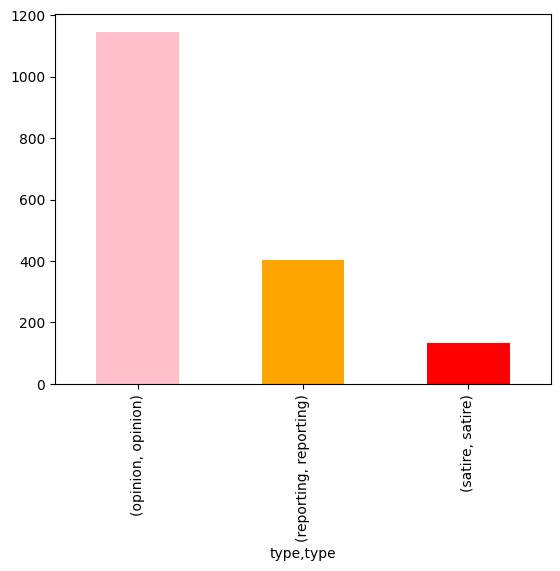

In [ ]:
train_df.groupby('type').type.value_counts().plot(kind = "bar", color = ["pink", "orange", "red"])
plt.show()

In [ ]:
#Downsampling opinion articles
opi=train_df[train_df['type']=='opinion']
opi=opi.sample(frac=0.5)
rest=train_df[train_df['type']!='opinion']
train_df=rest.append(opi)

/tmp/ipykernel_383202/2111642924.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df=rest.append(opi)


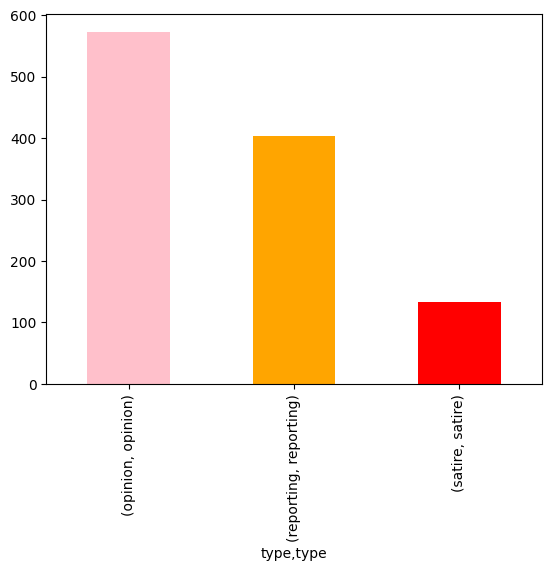

In [ ]:
train_df.groupby('type').type.value_counts().plot(kind = "bar", color = ["pink", "orange", "red"])
plt.show()

<AxesSubplot: >

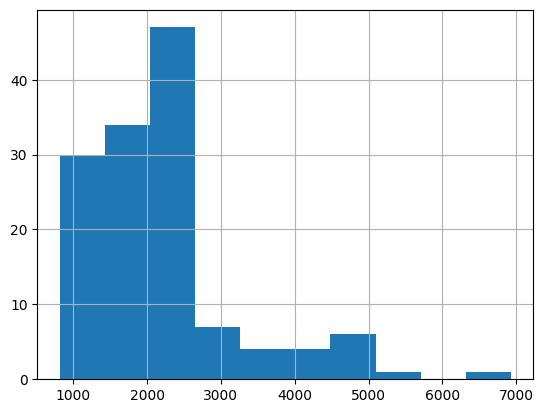

In [ ]:
#length of articles of type satire
train_df[train_df['type']=='satire']['text'].str.len().hist()

<AxesSubplot: >

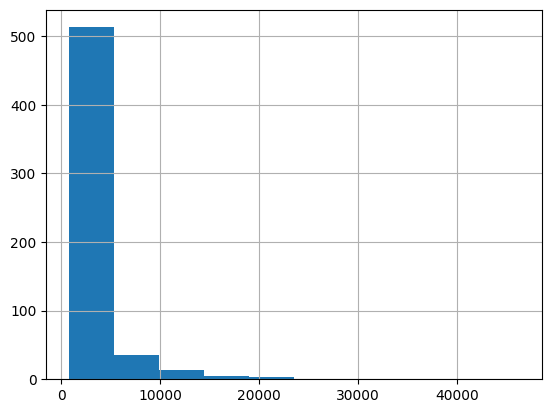

In [ ]:
#length of articles of type opinion
train_df[train_df['type']=='opinion']['text'].str.len().hist()

<AxesSubplot: >

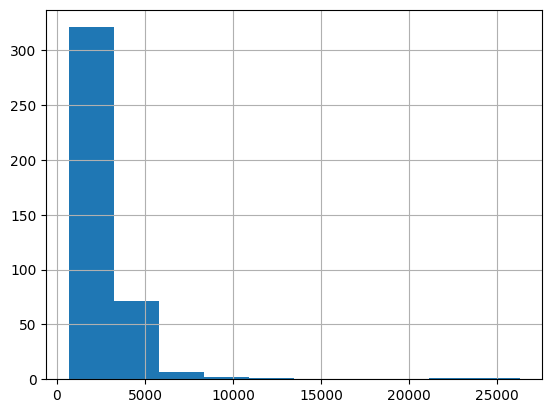

In [ ]:
#length of articles of type reporting
train_df[train_df['type']=='reporting']['text'].str.len().hist()

<AxesSubplot: >

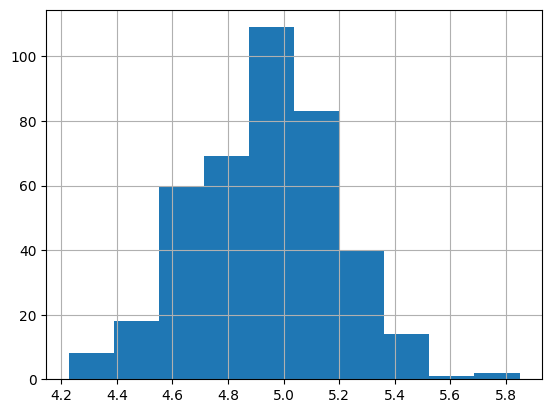

In [ ]:
# average word length (change type to see each one)
train_df[train_df['type']=='reporting']['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/osservatorio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<AxesSubplot: >

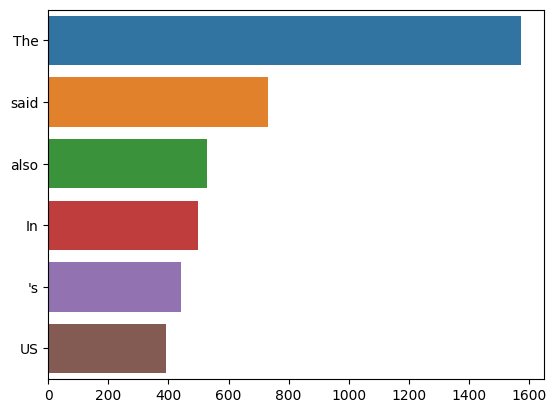

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop=set(stopwords.words('english'))
corpus=[]
new= train_df[train_df['type']=='reporting']['text'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
from collections import  Counter
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

In [ ]:
s = train_df[train_df['type']=='reporting']['text']

numbers = sum(c.isdigit() for c in s)
letters = sum(c.isalpha() for c in s)
spaces  = sum(c.isspace() for c in s)
others  = len(s) - numbers - letters - spaces
print(letters)

0


In [ ]:

# Code Snippet for Top Stopwords Barchart

import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords

def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

In [ ]:
# Code Snippet for Top N-grams Barchart

import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

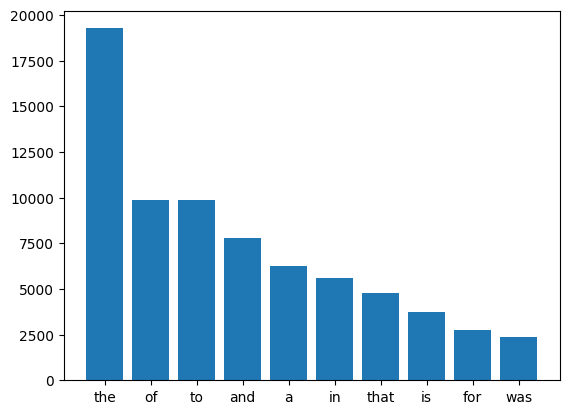

In [35]:
plot_top_stopwords_barchart(train_df[train_df['type']=='opinion']['text'])

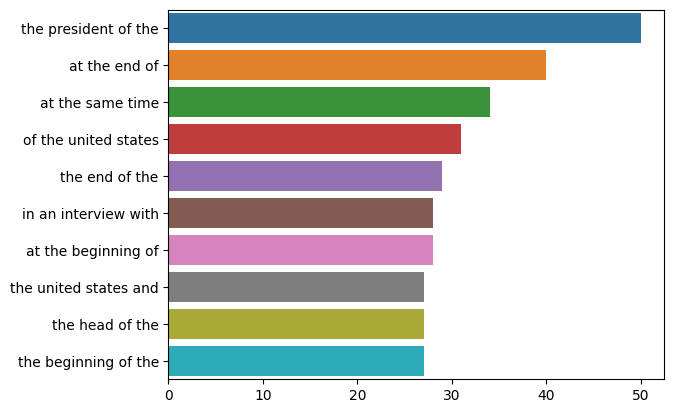

In [71]:
plot_top_ngrams_barchart(train_df[train_df['type']=='reporting']['text'],4)

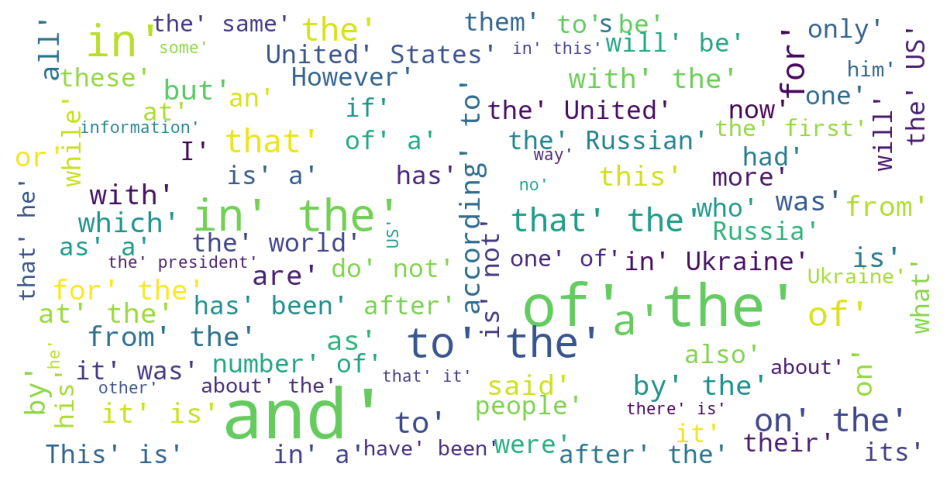

In [30]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)